In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Set random seeds and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
def load_data(file_path):
    # Load and shuffle full dataset
    full_data = pd.read_csv(file_path).sample(frac=1, random_state=42)
    X = full_data.drop('Outcome', axis=1).values.astype(np.float32)
    y = full_data['Outcome'].values.astype(np.int32)
    
    # Initial split: 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Split trainval into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
    )
    
    # Scale data properly
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = load_data(
    'D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv'
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1342176, 23), Val: (335544, 23), Test: (419430, 23)


In [3]:
# Create TensorDatasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

# Create DataLoaders
batch_size = 4096
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, pin_memory_device=str(device)
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, pin_memory_device=str(device)
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, pin_memory_device=str(device)
)

In [4]:
class EEGSeizureNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [5]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.best_roc = 0.0
        self.history = {'train_loss': [], 'val_loss': [], 
                       'train_acc': [], 'val_acc': [], 
                       'val_roc': []}

    def _run_epoch(self, loader, training=True):
        self.model.train(training)
        loss, correct, total = 0.0, 0, 0
        all_probs, all_labels = [], []
        
        with torch.set_grad_enabled(training):
            for inputs, labels in tqdm(loader, desc="Training" if training else "Validating"):
                inputs = inputs.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True).unsqueeze(1)
                
                if training: self.optimizer.zero_grad()
                outputs = self.model(inputs)
                batch_loss = self.criterion(outputs, labels)
                
                if training:
                    batch_loss.backward()
                    self.optimizer.step()
                
                loss += batch_loss.item()
                preds = (outputs >= 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                all_probs.append(outputs.detach().cpu())
                all_labels.append(labels.detach().cpu())
        
        return (loss/len(loader)), (correct/total)*100, \
               torch.cat(all_probs), torch.cat(all_labels)

    def train(self, train_loader, val_loader, epochs=50):
        for epoch in range(epochs):
            train_loss, train_acc, _, _ = self._run_epoch(train_loader)
            val_loss, val_acc, val_probs, val_labels = self._run_epoch(val_loader, False)
            
            # Calculate validation ROC AUC
            val_roc = roc_auc_score(val_labels.numpy(), val_probs.numpy())
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['val_roc'].append(val_roc)
            
            # Save best model
            if val_roc > self.best_roc:
                self.best_roc = val_roc
                torch.save(self.model.state_dict(), 'best_model_CNN.pth')

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
            print(f"Val ROC AUC: {val_roc:.4f}")
            print("-----------------------------------")

            
   
    def evaluate(self, test_loader):
        self.model.load_state_dict(torch.load('best_model.pth'))
        _, acc, probs, labels = self._run_epoch(test_loader, False)
        roc = roc_auc_score(labels.numpy(), probs.numpy())
        
        print("\n=== Final Test Performance ===")
        print(f"Accuracy: {acc:.2f}% | ROC AUC: {roc:.4f}")
        report = classification_report(labels.numpy(), (probs.numpy() >= 0.5).astype(int),
                                   target_names=['0', '1'], output_dict=True)
    
        # Save report as a JSON file
        report_path = "D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\Plots\\CNN.json"
        with open(report_path, "w") as f:
            json.dump(report, f, indent=4)

        print(f"Classification report saved to {report_path}")
        
        print(classification_report(labels.numpy(), (probs.numpy() >= 0.5).astype(int),
              target_names=['0', '1']))
        
        # Confusion Matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(confusion_matrix(labels, probs >= 0.5), 
                    annot=True, fmt='d', cmap='Blues')
        plt.title('Test Set Confusion Matrix')
        plt.show()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Test Set ROC Curve')
        plt.legend()
        plt.show()

    def plot_metrics(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(self.history['train_loss'], label='Train Loss')
        ax[0].plot(self.history['val_loss'], label='Val Loss')
        ax[0].set_title('Loss Curve')
        ax[0].legend()
        
        ax[1].plot(self.history['train_acc'], label='Train Accuracy')
        ax[1].plot(self.history['val_acc'], label='Val Accuracy')
        ax[1].set_title('Accuracy Curve')
        ax[1].legend()
        
        plt.show()


In [6]:
# Initialize model components
model = EEGSeizureNet(input_dim=X_train.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()

# Train model
trainer = Trainer(model, device, optimizer, criterion)
trainer.train(train_loader, val_loader, epochs=100)



alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.48it/s]

Epoch 1/100
Train Loss: 0.3988 | Val Loss: 0.3661
Train Acc: 81.68% | Val Acc: 83.29%
Val ROC AUC: 0.9154
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.53it/s]

Epoch 2/100
Train Loss: 0.3670 | Val Loss: 0.3450
Train Acc: 83.45% | Val Acc: 84.48%
Val ROC AUC: 0.9246
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.86it/s]

Epoch 3/100
Train Loss: 0.3531 | Val Loss: 0.3337
Train Acc: 84.17% | Val Acc: 85.18%
Val ROC AUC: 0.9298
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.32it/s]

Epoch 4/100
Train Loss: 0.3439 | Val Loss: 0.3248
Train Acc: 84.65% | Val Acc: 85.64%
Val ROC AUC: 0.9329
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 23.03it/s]

Epoch 5/100
Train Loss: 0.3368 | Val Loss: 0.3178
Train Acc: 85.03% | Val Acc: 86.04%
Val ROC AUC: 0.9361
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.77it/s]

Epoch 6/100
Train Loss: 0.3310 | Val Loss: 0.3102
Train Acc: 85.35% | Val Acc: 86.40%
Val ROC AUC: 0.9386
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.53it/s]

Epoch 7/100
Train Loss: 0.3258 | Val Loss: 0.3062
Train Acc: 85.65% | Val Acc: 86.66%
Val ROC AUC: 0.9405
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.99it/s]

Epoch 8/100
Train Loss: 0.3218 | Val Loss: 0.3025
Train Acc: 85.86% | Val Acc: 86.86%
Val ROC AUC: 0.9421
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.12it/s]

Epoch 9/100
Train Loss: 0.3186 | Val Loss: 0.2985
Train Acc: 86.04% | Val Acc: 87.07%
Val ROC AUC: 0.9435
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.85it/s]

Epoch 10/100
Train Loss: 0.3150 | Val Loss: 0.2939
Train Acc: 86.23% | Val Acc: 87.24%
Val ROC AUC: 0.9449
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.51it/s]

Epoch 11/100
Train Loss: 0.3117 | Val Loss: 0.2914
Train Acc: 86.42% | Val Acc: 87.43%
Val ROC AUC: 0.9461
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.23it/s]

Epoch 12/100
Train Loss: 0.3095 | Val Loss: 0.2876
Train Acc: 86.51% | Val Acc: 87.63%
Val ROC AUC: 0.9474
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.29it/s]

Epoch 13/100
Train Loss: 0.3070 | Val Loss: 0.2854
Train Acc: 86.64% | Val Acc: 87.72%
Val ROC AUC: 0.9480
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.90it/s]

Epoch 14/100
Train Loss: 0.3051 | Val Loss: 0.2843
Train Acc: 86.76% | Val Acc: 87.77%
Val ROC AUC: 0.9485
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.80it/s]

Epoch 15/100
Train Loss: 0.3032 | Val Loss: 0.2818
Train Acc: 86.86% | Val Acc: 87.93%
Val ROC AUC: 0.9497
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.17it/s]

Epoch 16/100
Train Loss: 0.3011 | Val Loss: 0.2795
Train Acc: 86.93% | Val Acc: 88.01%
Val ROC AUC: 0.9505
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.78it/s]

Epoch 17/100
Train Loss: 0.3000 | Val Loss: 0.2769
Train Acc: 87.06% | Val Acc: 88.12%
Val ROC AUC: 0.9513
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.57it/s]

Epoch 18/100
Train Loss: 0.2980 | Val Loss: 0.2756
Train Acc: 87.11% | Val Acc: 88.24%
Val ROC AUC: 0.9516
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.47it/s]

Epoch 19/100
Train Loss: 0.2961 | Val Loss: 0.2743
Train Acc: 87.23% | Val Acc: 88.29%
Val ROC AUC: 0.9524
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.03it/s]

Epoch 20/100
Train Loss: 0.2949 | Val Loss: 0.2726
Train Acc: 87.26% | Val Acc: 88.40%
Val ROC AUC: 0.9527
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.37it/s]

Epoch 21/100
Train Loss: 0.2935 | Val Loss: 0.2721
Train Acc: 87.35% | Val Acc: 88.46%
Val ROC AUC: 0.9533
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.25it/s]

Epoch 22/100
Train Loss: 0.2927 | Val Loss: 0.2698
Train Acc: 87.39% | Val Acc: 88.54%
Val ROC AUC: 0.9542
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.24it/s]

Epoch 23/100
Train Loss: 0.2916 | Val Loss: 0.2686
Train Acc: 87.46% | Val Acc: 88.60%
Val ROC AUC: 0.9545
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.19it/s]

Epoch 24/100
Train Loss: 0.2902 | Val Loss: 0.2673
Train Acc: 87.51% | Val Acc: 88.70%
Val ROC AUC: 0.9545
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.58it/s]

Epoch 25/100
Train Loss: 0.2887 | Val Loss: 0.2661
Train Acc: 87.61% | Val Acc: 88.77%
Val ROC AUC: 0.9556
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.11it/s]

Epoch 26/100
Train Loss: 0.2878 | Val Loss: 0.2654
Train Acc: 87.64% | Val Acc: 88.82%
Val ROC AUC: 0.9556
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.72it/s]

Epoch 27/100
Train Loss: 0.2867 | Val Loss: 0.2641
Train Acc: 87.72% | Val Acc: 88.85%
Val ROC AUC: 0.9563
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.21it/s]

Epoch 28/100
Train Loss: 0.2854 | Val Loss: 0.2629
Train Acc: 87.74% | Val Acc: 88.89%
Val ROC AUC: 0.9563
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.16it/s]

Epoch 29/100
Train Loss: 0.2853 | Val Loss: 0.2619
Train Acc: 87.78% | Val Acc: 88.94%
Val ROC AUC: 0.9569
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.32it/s]

Epoch 30/100
Train Loss: 0.2838 | Val Loss: 0.2605
Train Acc: 87.82% | Val Acc: 88.95%
Val ROC AUC: 0.9577
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.95it/s]

Epoch 31/100
Train Loss: 0.2833 | Val Loss: 0.2598
Train Acc: 87.90% | Val Acc: 89.05%
Val ROC AUC: 0.9571
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.96it/s]

Epoch 32/100
Train Loss: 0.2822 | Val Loss: 0.2587
Train Acc: 87.91% | Val Acc: 89.11%
Val ROC AUC: 0.9579
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.36it/s]

Epoch 33/100
Train Loss: 0.2817 | Val Loss: 0.2570
Train Acc: 87.97% | Val Acc: 89.20%
Val ROC AUC: 0.9583
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.25it/s]

Epoch 34/100
Train Loss: 0.2802 | Val Loss: 0.2571
Train Acc: 88.01% | Val Acc: 89.18%
Val ROC AUC: 0.9586
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.66it/s]

Epoch 35/100
Train Loss: 0.2797 | Val Loss: 0.2549
Train Acc: 88.05% | Val Acc: 89.30%
Val ROC AUC: 0.9591
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.39it/s]

Epoch 36/100
Train Loss: 0.2788 | Val Loss: 0.2542
Train Acc: 88.09% | Val Acc: 89.32%
Val ROC AUC: 0.9594
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.95it/s]

Epoch 37/100
Train Loss: 0.2784 | Val Loss: 0.2537
Train Acc: 88.13% | Val Acc: 89.32%
Val ROC AUC: 0.9594
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.39it/s]

Epoch 38/100
Train Loss: 0.2780 | Val Loss: 0.2524
Train Acc: 88.17% | Val Acc: 89.43%
Val ROC AUC: 0.9595
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.89it/s]

Epoch 39/100
Train Loss: 0.2772 | Val Loss: 0.2523
Train Acc: 88.19% | Val Acc: 89.42%
Val ROC AUC: 0.9600
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.56it/s]

Epoch 40/100
Train Loss: 0.2762 | Val Loss: 0.2522
Train Acc: 88.28% | Val Acc: 89.43%
Val ROC AUC: 0.9603
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.41it/s]

Epoch 41/100
Train Loss: 0.2755 | Val Loss: 0.2512
Train Acc: 88.26% | Val Acc: 89.44%
Val ROC AUC: 0.9607
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.70it/s]

Epoch 42/100
Train Loss: 0.2750 | Val Loss: 0.2497
Train Acc: 88.30% | Val Acc: 89.52%
Val ROC AUC: 0.9610
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.63it/s]

Epoch 43/100
Train Loss: 0.2742 | Val Loss: 0.2497
Train Acc: 88.36% | Val Acc: 89.57%
Val ROC AUC: 0.9608
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.86it/s]

Epoch 44/100
Train Loss: 0.2737 | Val Loss: 0.2488
Train Acc: 88.38% | Val Acc: 89.62%
Val ROC AUC: 0.9612
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.98it/s]

Epoch 45/100
Train Loss: 0.2730 | Val Loss: 0.2474
Train Acc: 88.40% | Val Acc: 89.71%
Val ROC AUC: 0.9615
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.12it/s]

Epoch 46/100
Train Loss: 0.2724 | Val Loss: 0.2471
Train Acc: 88.42% | Val Acc: 89.69%
Val ROC AUC: 0.9617
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.77it/s]

Epoch 47/100
Train Loss: 0.2723 | Val Loss: 0.2478
Train Acc: 88.45% | Val Acc: 89.69%
Val ROC AUC: 0.9618
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.32it/s]

Epoch 48/100
Train Loss: 0.2713 | Val Loss: 0.2453
Train Acc: 88.48% | Val Acc: 89.81%
Val ROC AUC: 0.9623
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.74it/s]

Epoch 49/100
Train Loss: 0.2711 | Val Loss: 0.2451
Train Acc: 88.48% | Val Acc: 89.78%
Val ROC AUC: 0.9626
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.11it/s]

Epoch 50/100
Train Loss: 0.2705 | Val Loss: 0.2443
Train Acc: 88.52% | Val Acc: 89.87%
Val ROC AUC: 0.9627
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.53it/s]

Epoch 51/100
Train Loss: 0.2702 | Val Loss: 0.2444
Train Acc: 88.52% | Val Acc: 89.86%
Val ROC AUC: 0.9630
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.88it/s]

Epoch 52/100
Train Loss: 0.2696 | Val Loss: 0.2450
Train Acc: 88.60% | Val Acc: 89.84%
Val ROC AUC: 0.9630
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.52it/s]

Epoch 53/100
Train Loss: 0.2691 | Val Loss: 0.2427
Train Acc: 88.61% | Val Acc: 89.96%
Val ROC AUC: 0.9629
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.12it/s]

Epoch 54/100
Train Loss: 0.2683 | Val Loss: 0.2422
Train Acc: 88.63% | Val Acc: 89.97%
Val ROC AUC: 0.9634
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.85it/s]

Epoch 55/100
Train Loss: 0.2679 | Val Loss: 0.2420
Train Acc: 88.68% | Val Acc: 90.05%
Val ROC AUC: 0.9635
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.13it/s]

Epoch 56/100
Train Loss: 0.2675 | Val Loss: 0.2419
Train Acc: 88.70% | Val Acc: 89.99%
Val ROC AUC: 0.9636
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.14it/s]

Epoch 57/100
Train Loss: 0.2670 | Val Loss: 0.2403
Train Acc: 88.72% | Val Acc: 90.06%
Val ROC AUC: 0.9639
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.07it/s]

Epoch 58/100
Train Loss: 0.2667 | Val Loss: 0.2399
Train Acc: 88.75% | Val Acc: 90.08%
Val ROC AUC: 0.9639
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.14it/s]

Epoch 59/100
Train Loss: 0.2662 | Val Loss: 0.2409
Train Acc: 88.74% | Val Acc: 90.06%
Val ROC AUC: 0.9641
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.84it/s]

Epoch 60/100
Train Loss: 0.2660 | Val Loss: 0.2390
Train Acc: 88.74% | Val Acc: 90.14%
Val ROC AUC: 0.9643
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.04it/s]

Epoch 61/100
Train Loss: 0.2656 | Val Loss: 0.2403
Train Acc: 88.81% | Val Acc: 90.13%
Val ROC AUC: 0.9640
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.54it/s]

Epoch 62/100
Train Loss: 0.2650 | Val Loss: 0.2399
Train Acc: 88.84% | Val Acc: 90.08%
Val ROC AUC: 0.9644
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.13it/s]

Epoch 63/100
Train Loss: 0.2644 | Val Loss: 0.2387
Train Acc: 88.84% | Val Acc: 90.16%
Val ROC AUC: 0.9648
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.89it/s]

Epoch 64/100
Train Loss: 0.2647 | Val Loss: 0.2368
Train Acc: 88.86% | Val Acc: 90.24%
Val ROC AUC: 0.9648
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.87it/s]

Epoch 65/100
Train Loss: 0.2639 | Val Loss: 0.2368
Train Acc: 88.88% | Val Acc: 90.26%
Val ROC AUC: 0.9650
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.62it/s]

Epoch 66/100
Train Loss: 0.2635 | Val Loss: 0.2360
Train Acc: 88.89% | Val Acc: 90.29%
Val ROC AUC: 0.9653
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.39it/s]

Epoch 67/100
Train Loss: 0.2632 | Val Loss: 0.2365
Train Acc: 88.92% | Val Acc: 90.28%
Val ROC AUC: 0.9655
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.32it/s]

Epoch 68/100
Train Loss: 0.2630 | Val Loss: 0.2366
Train Acc: 88.91% | Val Acc: 90.27%
Val ROC AUC: 0.9655
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.79it/s]

Epoch 69/100
Train Loss: 0.2625 | Val Loss: 0.2349
Train Acc: 88.96% | Val Acc: 90.32%
Val ROC AUC: 0.9656
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.91it/s]

Epoch 70/100
Train Loss: 0.2619 | Val Loss: 0.2346
Train Acc: 88.96% | Val Acc: 90.34%
Val ROC AUC: 0.9659
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.58it/s]

Epoch 71/100
Train Loss: 0.2624 | Val Loss: 0.2347
Train Acc: 88.97% | Val Acc: 90.36%
Val ROC AUC: 0.9656
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.15it/s]

Epoch 72/100
Train Loss: 0.2617 | Val Loss: 0.2336
Train Acc: 88.98% | Val Acc: 90.39%
Val ROC AUC: 0.9661
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.80it/s]

Epoch 73/100
Train Loss: 0.2608 | Val Loss: 0.2347
Train Acc: 89.03% | Val Acc: 90.35%
Val ROC AUC: 0.9662
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.21it/s]

Epoch 74/100
Train Loss: 0.2607 | Val Loss: 0.2344
Train Acc: 89.04% | Val Acc: 90.40%
Val ROC AUC: 0.9658
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.43it/s]

Epoch 75/100
Train Loss: 0.2606 | Val Loss: 0.2335
Train Acc: 89.02% | Val Acc: 90.50%
Val ROC AUC: 0.9663
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.88it/s]

Epoch 76/100
Train Loss: 0.2604 | Val Loss: 0.2332
Train Acc: 89.06% | Val Acc: 90.46%
Val ROC AUC: 0.9661
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.71it/s]

Epoch 77/100
Train Loss: 0.2595 | Val Loss: 0.2321
Train Acc: 89.07% | Val Acc: 90.52%
Val ROC AUC: 0.9665
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 22.00it/s]

Epoch 78/100
Train Loss: 0.2594 | Val Loss: 0.2331
Train Acc: 89.09% | Val Acc: 90.45%
Val ROC AUC: 0.9665
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.86it/s]

Epoch 79/100
Train Loss: 0.2592 | Val Loss: 0.2319
Train Acc: 89.11% | Val Acc: 90.53%
Val ROC AUC: 0.9666
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.76it/s]

Epoch 80/100
Train Loss: 0.2584 | Val Loss: 0.2311
Train Acc: 89.12% | Val Acc: 90.55%
Val ROC AUC: 0.9667
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.65it/s]

Epoch 81/100
Train Loss: 0.2591 | Val Loss: 0.2306
Train Acc: 89.12% | Val Acc: 90.59%
Val ROC AUC: 0.9667
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.35it/s]

Epoch 82/100
Train Loss: 0.2586 | Val Loss: 0.2320
Train Acc: 89.15% | Val Acc: 90.51%
Val ROC AUC: 0.9670
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.65it/s]

Epoch 83/100
Train Loss: 0.2584 | Val Loss: 0.2305
Train Acc: 89.14% | Val Acc: 90.57%
Val ROC AUC: 0.9671
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.25it/s]

Epoch 84/100
Train Loss: 0.2580 | Val Loss: 0.2304
Train Acc: 89.19% | Val Acc: 90.61%
Val ROC AUC: 0.9671
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.74it/s]

Epoch 85/100
Train Loss: 0.2576 | Val Loss: 0.2298
Train Acc: 89.21% | Val Acc: 90.67%
Val ROC AUC: 0.9672
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.60it/s]

Epoch 86/100
Train Loss: 0.2574 | Val Loss: 0.2285
Train Acc: 89.19% | Val Acc: 90.64%
Val ROC AUC: 0.9676
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 20.97it/s]

Epoch 87/100
Train Loss: 0.2568 | Val Loss: 0.2284
Train Acc: 89.23% | Val Acc: 90.69%
Val ROC AUC: 0.9677
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.37it/s]

Epoch 88/100
Train Loss: 0.2571 | Val Loss: 0.2288
Train Acc: 89.23% | Val Acc: 90.68%
Val ROC AUC: 0.9677
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.22it/s]

Epoch 89/100
Train Loss: 0.2569 | Val Loss: 0.2290
Train Acc: 89.23% | Val Acc: 90.73%
Val ROC AUC: 0.9672
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.60it/s]

Epoch 90/100
Train Loss: 0.2560 | Val Loss: 0.2279
Train Acc: 89.27% | Val Acc: 90.81%
Val ROC AUC: 0.9676
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.31it/s]

Epoch 91/100
Train Loss: 0.2562 | Val Loss: 0.2272
Train Acc: 89.26% | Val Acc: 90.73%
Val ROC AUC: 0.9679
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.74it/s]

Epoch 92/100
Train Loss: 0.2562 | Val Loss: 0.2276
Train Acc: 89.27% | Val Acc: 90.79%
Val ROC AUC: 0.9677
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.86it/s]

Epoch 93/100
Train Loss: 0.2554 | Val Loss: 0.2275
Train Acc: 89.31% | Val Acc: 90.75%
Val ROC AUC: 0.9678
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.26it/s]

Epoch 94/100
Train Loss: 0.2556 | Val Loss: 0.2266
Train Acc: 89.28% | Val Acc: 90.73%
Val ROC AUC: 0.9681
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.16it/s]

Epoch 95/100
Train Loss: 0.2551 | Val Loss: 0.2275
Train Acc: 89.31% | Val Acc: 90.74%
Val ROC AUC: 0.9680
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.40it/s]

Epoch 96/100
Train Loss: 0.2551 | Val Loss: 0.2263
Train Acc: 89.32% | Val Acc: 90.83%
Val ROC AUC: 0.9677
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.64it/s]

Epoch 97/100
Train Loss: 0.2549 | Val Loss: 0.2254
Train Acc: 89.33% | Val Acc: 90.86%
Val ROC AUC: 0.9682
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.97it/s]

Epoch 98/100
Train Loss: 0.2547 | Val Loss: 0.2256
Train Acc: 89.32% | Val Acc: 90.85%
Val ROC AUC: 0.9685
-----------------------------------




alidating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.24it/s]

Epoch 99/100
Train Loss: 0.2542 | Val Loss: 0.2253
Train Acc: 89.38% | Val Acc: 90.89%
Val ROC AUC: 0.9684
-----------------------------------



Validating: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 21.79it/s]

Epoch 100/100
Train Loss: 0.2543 | Val Loss: 0.2261
Train Acc: 89.39% | Val Acc: 90.84%
Val ROC AUC: 0.9683
-----------------------------------



alidating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.47it/s]


=== Final Test Performance ===
Accuracy: 90.85% | ROC AUC: 0.9684
Classification report saved to D:\MOOC.fi\Jupyter\EEG\Dataset\Plots\CNN.json
              precision    recall  f1-score   support

           0       0.87      0.95      0.91    209715
           1       0.95      0.86      0.90    209715

    accuracy                           0.91    419430
   macro avg       0.91      0.91      0.91    419430
weighted avg       0.91      0.91      0.91    419430



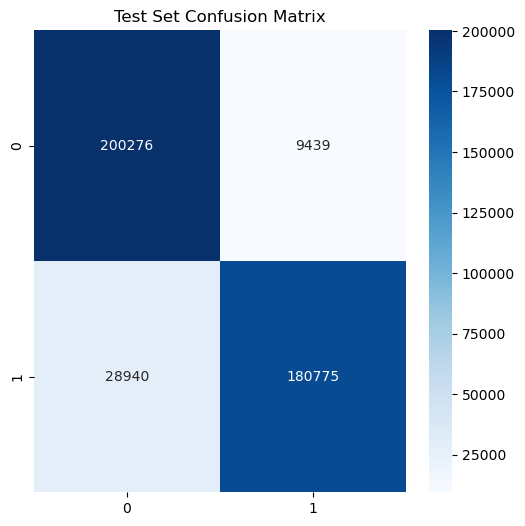

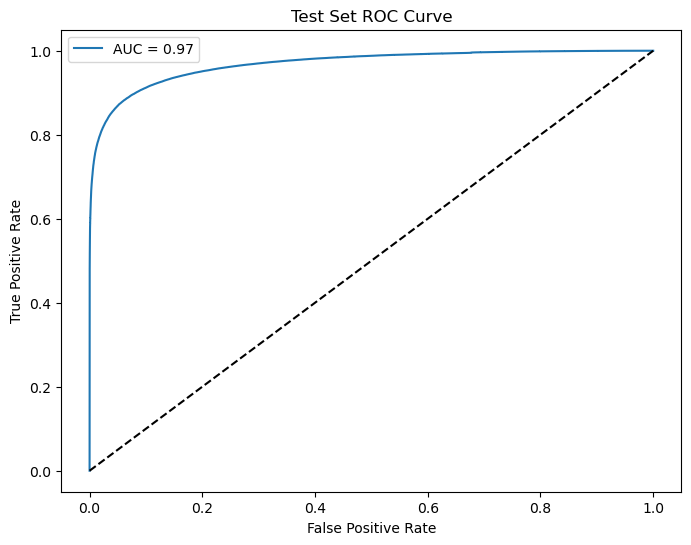

In [9]:
import json
trainer.evaluate(test_loader)

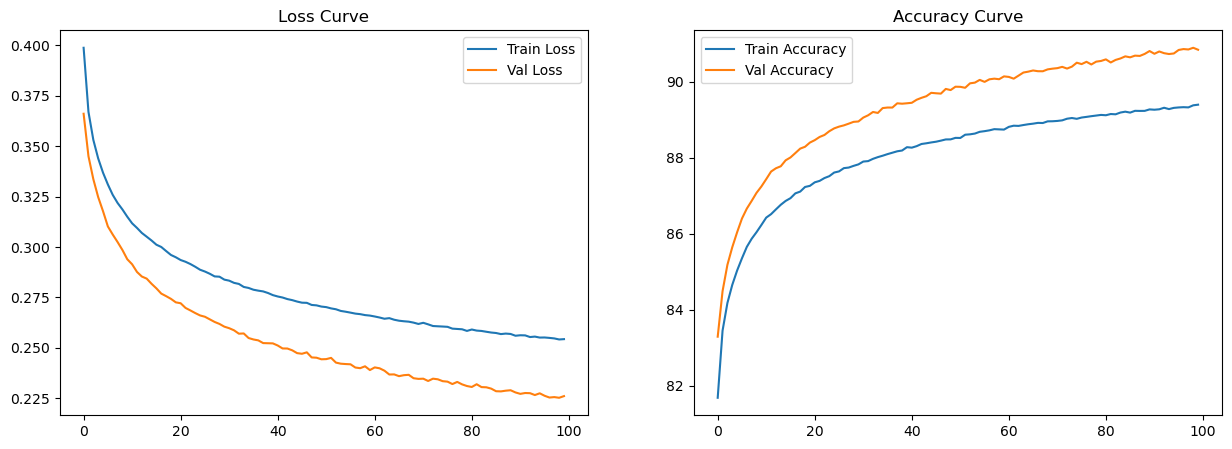

In [10]:
trainer.plot_metrics()